# Training


In [ ]:
import csv
import pandas as pd
import numpy as np
import string
import nltk
import tweepy
from nltk import word_tokenize, re
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
nltk.download('stopwords')
nltk.download('punkt')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
from google.colab import files

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# uploaded = files.upload()

In [ ]:
def load_dataset(filename, cols):
    dataset = pd.read_csv(filename, encoding='latin-1')
    dataset.columns = cols
    return dataset

def remove_cols(dataset, cols):
    for col in cols:
        del dataset[col]
    return dataset

def preprocess_tweet_text(tweet):
    tweet.lower()
    # Remove urls
    tweet = re.sub(r"http\S+|www\S+|https\S+", '', tweet, flags=re.MULTILINE)
    # Remove #hashtags
    tweet = re.sub(r'#[\s]', '', tweet)
    # Remove RT
    tweet = re.sub(r'RT[\s]+', '', tweet)
    # Remove user @ references
    tweet = re.sub(r'@[A-Za-z0-9]+', '', tweet)
    # Remove punctuations
    tweet = tweet.translate(str.maketrans('', '', string.punctuation))
    # Remove stopwords
    tweet_tokens = word_tokenize(tweet)
    filtered_words = [w for w in tweet_tokens if not w in stop_words]
    return " ".join(filtered_words)

def get_feature_vector(train_fit):
    vector = TfidfVectorizer(sublinear_tf=True)
    vector.fit(train_fit)
    return vector

def int_to_string(sentiment):
    if sentiment == 0:
        return "Negative"
    elif sentiment == 2:
        return "Neutral"
    elif sentiment == 4:
        return "Positive"


In [ ]:
# Load dataset
dataset = load_dataset("/content/drive/My Drive/data/training.csv", ['target', 't_id', 'created_at', 'query', 'user', 'text'])
# Remove unwanted columns from dataset
n_dataset = remove_cols(dataset, ['t_id', 'created_at', 'query', 'user'])
# Preprocess data
dataset.text = dataset['text'].apply(preprocess_tweet_text)

# Split dataset into Train, Test
# Same tf vector will be used for testing sentiments on unseen trending data
tf_vector = get_feature_vector(np.array(dataset.iloc[:, 1]).ravel())
X = tf_vector.transform(np.array(dataset.iloc[:, 1]).ravel())
y = np.array(dataset.iloc[:, 0]).ravel()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=30)


In [ ]:
# Training Naive Bayes model
NB_model = MultinomialNB()
NB_model.fit(X_train, y_train)
y_predict_nb = NB_model.predict(X_test)
print(accuracy_score(y_test, y_predict_nb))

# Training Logistic Regression model
LR_model = LogisticRegression(solver='lbfgs', max_iter=10000000)
LR_model.fit(X_train, y_train)
y_predict_lr = LR_model.predict(X_test)
print(accuracy_score(y_test, y_predict_lr))

0.768384375
0.7885


# Testing

In [ ]:
test_ds = load_dataset("/content/drive/My Drive/data/tweets.csv", ["t_id", "hashtag", "created_at", "user", "text"])
test_ds = remove_cols(test_ds, ["t_id", "created_at"])
test_ds.text = test_ds.text.astype(str)
# test_ds = load_dataset("/content/drive/My Drive/data/tweets.csv", ["hashtag", "text"])
# test_ds.text = test_ds.text.astype(str)
# Creating text feature
test_ds.text = test_ds["text"].apply(preprocess_tweet_text)
test_feature = tf_vector.transform(np.array(test_ds.iloc[:, 2]).ravel())

# Using models for prediction
test_prediction_lr = LR_model.predict(test_feature)
test_prediction_nb = NB_model.predict(test_feature)

In [ ]:
# Putting result into DF
test_result_lr = pd.DataFrame({'prediction': test_prediction_lr, 'hashtag': test_ds.hashtag, 'text': test_ds.text, 'user': test_ds.user})
test_result_lr = test_result_lr.drop_duplicates(subset=['text'], keep='first').sort_values(by=['prediction', 'text'], ignore_index=True)
test_result_lr.columns = ['prediction', 'hashtag', 'text', 'user']
test_result_lr.prediction = test_result_lr['prediction'].apply(int_to_string)
test_result_lr.to_csv(r'resultslr.csv', index=False,header=True)
print(test_result_lr)


   prediction  ...             user
0    Negative  ...            tyler
1    Negative  ...    BarstoolTrent
2    Negative  ...  viallnicholas28
3    Negative  ...    FrankKhalidUK
4    Negative  ...    JamesMelville
..        ...  ...              ...
89   Positive  ...     GrrrGraphics
90   Positive  ...     blakeshelton
91   Positive  ...     GrrrGraphics
92   Positive  ...             Wale
93   Positive  ...      ArtofLiving

[94 rows x 4 columns]


In [ ]:
test_result_nb = pd.DataFrame({'prediction': test_prediction_nb, 'hashtag': test_ds.hashtag, 'text': test_ds.text, 'user': test_ds.user})
test_result_nb = test_result_nb.drop_duplicates(subset=['text'], keep='first').sort_values(by=['prediction', 'text'], ignore_index=True)
test_result_nb.columns = ['prediction', 'hashtag', 'text', 'user']
test_result_nb.prediction = test_result_nb['prediction'].apply(int_to_string)
test_result_nb.to_csv(r'resultsnb.csv', index=False,header=True)
print(test_result_nb)

   prediction  ...           user
0    Negative  ...  BarstoolTrent
1    Negative  ...      Excellion
2    Negative  ...  BarstoolTrent
3    Negative  ...          tyler
4    Negative  ...  BarstoolTrent
..        ...  ...            ...
89   Positive  ...         NASCAR
90   Positive  ...   GrrrGraphics
91   Positive  ...   blakeshelton
92   Positive  ...           Wale
93   Positive  ...    ArtofLiving

[94 rows x 4 columns]


# Visualizing Data

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
plot_size = plt.rcParams["figure.figsize"] 
print(plot_size[0]) 
print(plot_size[1])

plot_size[0] = 8
plot_size[1] = 6
plt.rcParams["figure.figsize"] = plot_size 

6.0
4.0


# Logistic Regression Results

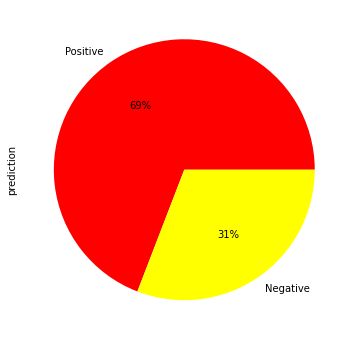

In [ ]:
# Logistic Regression
test_result_lr.prediction.value_counts().plot(kind='pie', autopct='%1.0f%%', colors=["red", "yellow", "green"])

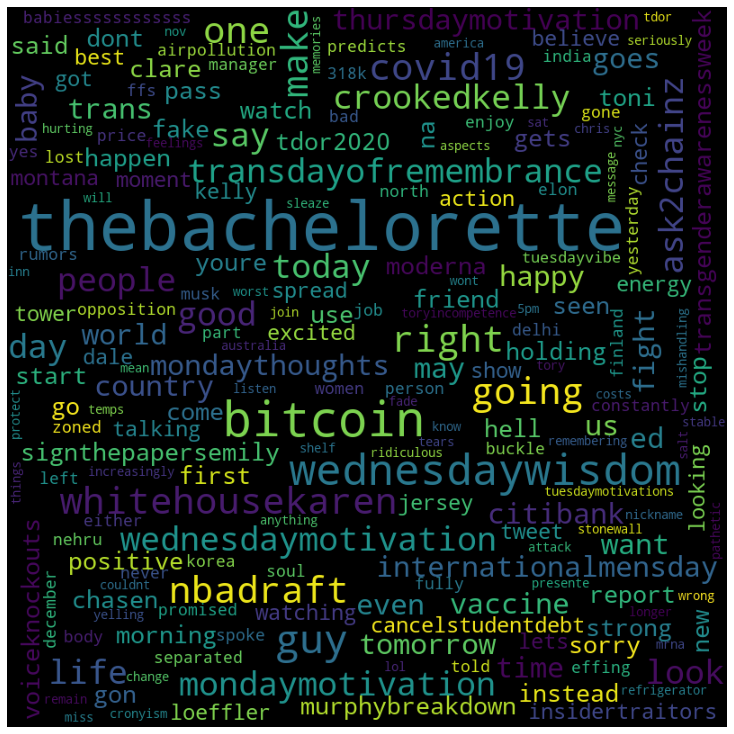

In [ ]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
# LR total map


data = test_result_lr
    
#Setting the comment and stop words
comment_words = '' 
stop_words = set(STOPWORDS)
# Iterating through the .csv data file 
for i in data.text: 
    i = str(i) 
    seperate = i.split() 
    for j in range(len(seperate)): 
        seperate[j] = seperate[j].lower() 
      
    comment_words += " ".join(seperate)+" "
# Create the Word Cloud
final_wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='black', 
                stopwords = stop_words, 
                min_font_size = 10).generate(comment_words)
# Plotting the WordCloud                    
plt.figure(figsize = (10, 10), facecolor = None) 
plt.imshow(final_wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

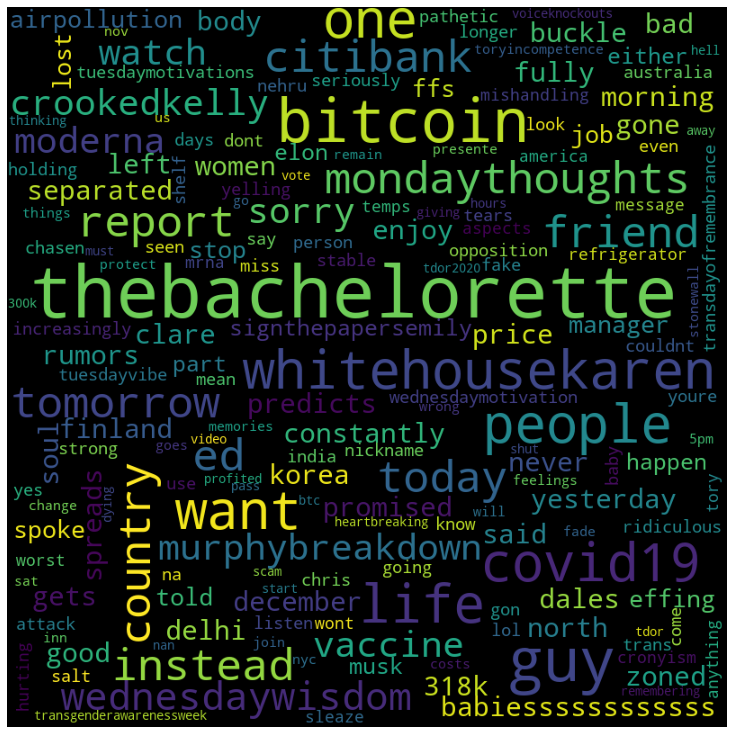

In [ ]:
# LR negative map

options = ['Negative']
data_neg = test_result_lr.loc[test_result_lr['prediction'].isin(options)]  
    
#Setting the comment and stop words
comment_words = '' 
stop_words = set(STOPWORDS)
# Iterating through the .csv data file 
for i in data_neg.text: 
    i = str(i) 
    seperate = i.split() 
    for j in range(len(seperate)): 
        seperate[j] = seperate[j].lower() 
      
    comment_words += " ".join(seperate)+" "
# Create the Word Cloud
final_wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='black', 
                stopwords = stop_words, 
                min_font_size = 10).generate(comment_words)
# Plotting the WordCloud                    
plt.figure(figsize = (10, 10), facecolor = None) 
plt.imshow(final_wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

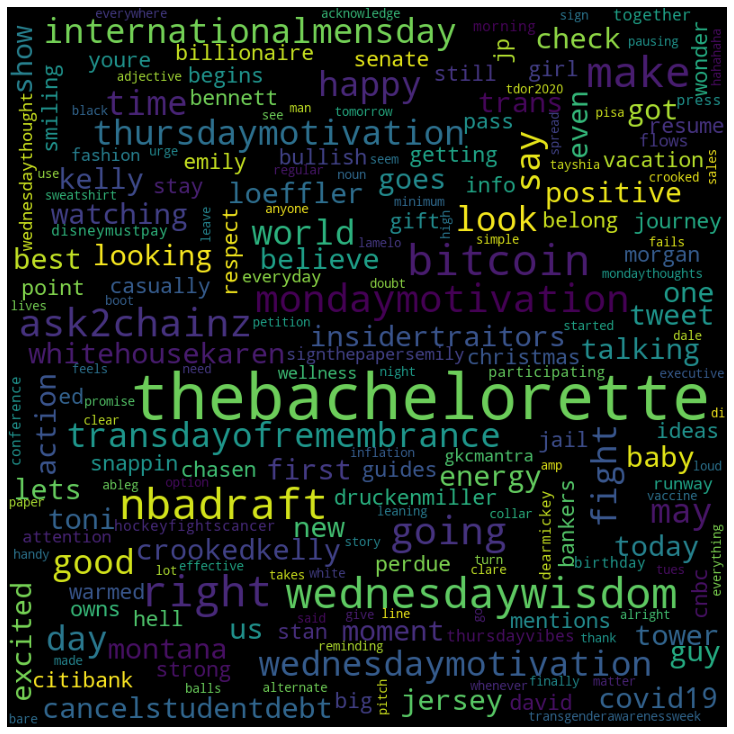

In [ ]:
# LR positive map

options = ['Positive']
data_pos = test_result_lr.loc[test_result_lr['prediction'].isin(options)]  
    
#Setting the comment and stop words
comment_words = '' 
stop_words = set(STOPWORDS)
# Iterating through the .csv data file 
for i in data_pos.text: 
    i = str(i) 
    seperate = i.split() 
    for j in range(len(seperate)): 
        seperate[j] = seperate[j].lower() 
      
    comment_words += " ".join(seperate)+" "
# Create the Word Cloud
final_wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='black', 
                stopwords = stop_words, 
                min_font_size = 10).generate(comment_words)
# Plotting the WordCloud                    
plt.figure(figsize = (10, 10), facecolor = None) 
plt.imshow(final_wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

# Naive Bayes Results

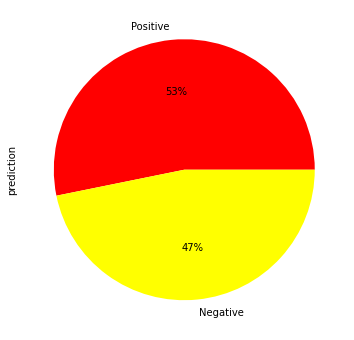

In [ ]:
# naive bayes
test_result_nb.prediction.value_counts().plot(kind='pie', autopct='%1.0f%%', colors=["red", "yellow", "green"])

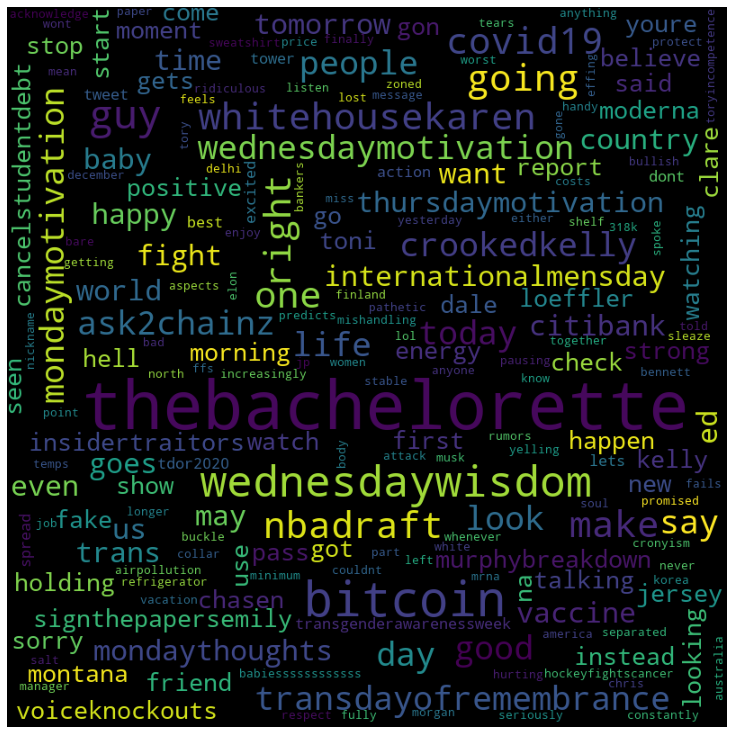

In [ ]:
# NB total map
data = test_result_nb
    
#Setting the comment and stop words
comment_words = '' 
stop_words = set(STOPWORDS)
# Iterating through the .csv data file 
for i in data.text: 
    i = str(i) 
    seperate = i.split() 
    for j in range(len(seperate)): 
        seperate[j] = seperate[j].lower() 
      
    comment_words += " ".join(seperate)+" "
# Create the Word Cloud
final_wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='black', 
                stopwords = stop_words, 
                min_font_size = 10).generate(comment_words)
# Plotting the WordCloud                    
plt.figure(figsize = (10, 10), facecolor = None) 
plt.imshow(final_wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

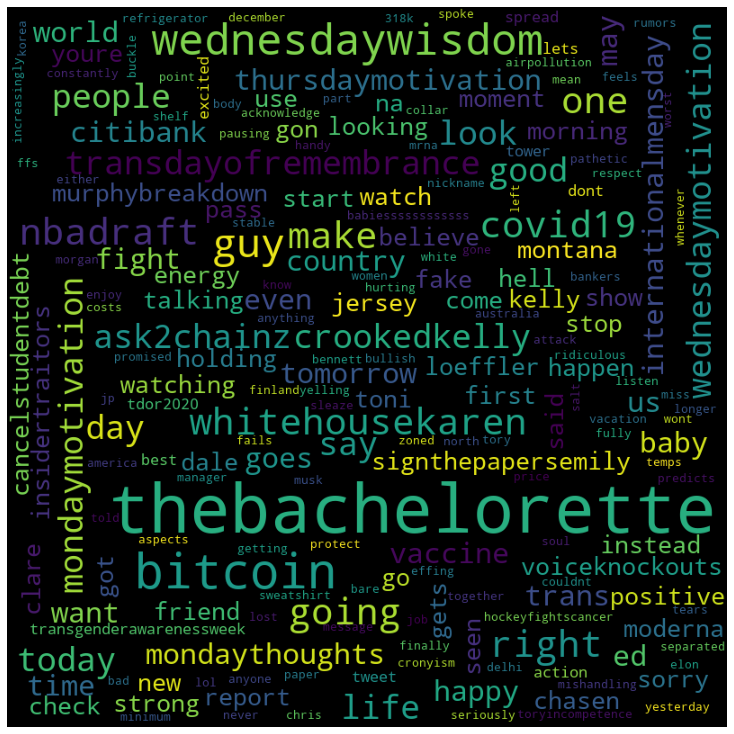

In [ ]:
# NB negative map


options = ['Negative']
data_neg = test_result_nb.loc[test_result_nb['prediction'].isin(options)]  
    
#Setting the comment and stop words
comment_words = '' 
stop_words = set(STOPWORDS)
# Iterating through the .csv data file 
for i in data.text: 
    i = str(i) 
    seperate = i.split() 
    for j in range(len(seperate)): 
        seperate[j] = seperate[j].lower() 
      
    comment_words += " ".join(seperate)+" "
# Create the Word Cloud
final_wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='black', 
                stopwords = stop_words, 
                min_font_size = 10).generate(comment_words)
# Plotting the WordCloud                    
plt.figure(figsize = (10, 10), facecolor = None) 
plt.imshow(final_wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

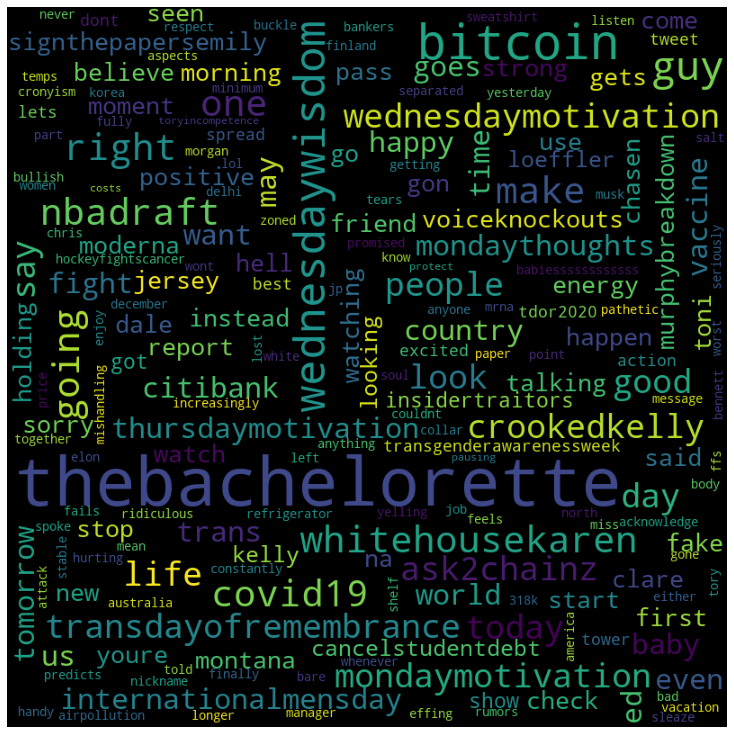

In [ ]:
# NB positive map


options = ['Positive']
data_neg = test_result_nb.loc[test_result_nb['prediction'].isin(options)]  
    
#Setting the comment and stop words
comment_words = '' 
stop_words = set(STOPWORDS)
# Iterating through the .csv data file 
for i in data.text: 
    i = str(i) 
    seperate = i.split() 
    for j in range(len(seperate)): 
        seperate[j] = seperate[j].lower() 
      
    comment_words += " ".join(seperate)+" "
# Create the Word Cloud
final_wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='black', 
                stopwords = stop_words, 
                min_font_size = 10).generate(comment_words)
# Plotting the WordCloud                    
plt.figure(figsize = (10, 10), facecolor = None) 
plt.imshow(final_wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()